In [1]:
% matplotlib inline

# Introduction

This notebook demonstrates how to use TensorFlow's `Dataset` functionality. Using a `Dataset` can **significantly** speed up training by establishing an input pipeline that is decoupled from the model. This decoupling allows preparation of data using the CPU while the GPU is training on a previous batch of data, ensuring high, constant GPU utilization.

We will use the fashion MNIST dataset (conveniently accessible from TensorFlow). Like MNIST, Fashion MNIST contains 70000 28x28 pixel grayscale images from 10 categories.

In [2]:
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

/home/dwyatte/GitHub/dwyatte/tensorflow-high-level-apis/venv/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


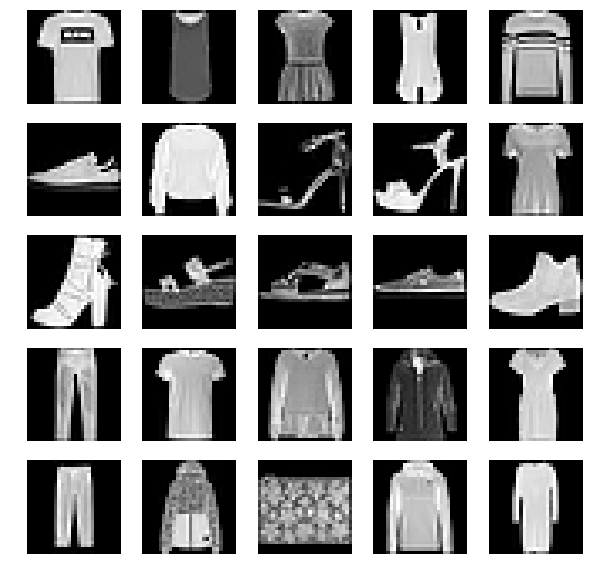

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for i in range(1, 26):
    plt.subplot(5, 5, i)
    plt.imshow(train_images[i], cmap='gray')
    plt.axis('off')

Let's build a simple model to classify the article of clothing. This model is overparameterized for a toy dataset like this, but simulates real conditions where training on a single batch of data is an expensive operation. 

In [4]:
import tensorflow as tf

inputs = tf.placeholder(tf.float32, (None, 28, 28))
labels = tf.placeholder(tf.int64, (None))

expand = tf.expand_dims(inputs, -1)
conv1a = tf.layers.conv2d(expand, 256, (3, 3), activation='relu')
conv1b = tf.layers.conv2d(conv1a, 256, (3, 3), activation='relu')
pool1 = tf.layers.max_pooling2d(conv1b, (2, 2), strides=(2, 2), padding='same')
conv2a = tf.layers.conv2d(pool1, 512, (3, 3), activation='relu')
conv2b = tf.layers.conv2d(conv2a, 512, (3, 3), activation='relu')
pool2 = tf.layers.max_pooling2d(conv2b, (2, 2), strides=(2, 2))
flat = tf.layers.flatten(pool2)
fc1 = tf.layers.dense(flat, 4096, activation='relu')
fc2 = tf.layers.dense(fc1, 4096, activation='relu')
logits = tf.layers.dense(fc2, 10, activation='relu')

loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
opt = tf.train.GradientDescentOptimizer(learning_rate=0.0001).minimize(loss)

In [5]:
def yield_batches(images, labels, batch_size):
    assert len(images) == len(labels)
    for i in range(0, len(images), batch_size):
        yield images[i:i+batch_size], labels[i:i+batch_size]

In [6]:
batch_size = 512

init = tf.global_variables_initializer()
train_loss = []
test_loss = []

with tf.Session() as sess:
    sess.run(init)
    
    # train
    for batch_inputs, batch_labels in yield_batches(train_images, train_labels, batch_size):
        l, _ = sess.run([loss, opt], feed_dict={inputs: batch_inputs, labels: batch_labels})
        train_loss.append(l)

    # test
    for batch_inputs, batch_labels in yield_batches(test_images, test_labels, batch_size):
        l = sess.run(loss, feed_dict={inputs: batch_inputs, labels: batch_labels})
        test_loss.append(l)

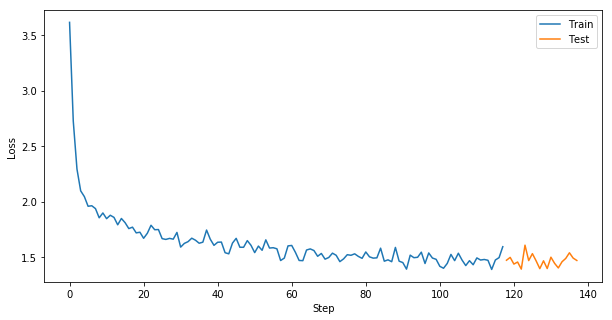

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_loss)), train_loss)
plt.plot(range(len(train_loss), len(train_loss)+len(test_loss)), test_loss)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend(('Train', 'Test'))

# GPU Utilization

Realistically, our dataset would not fit in memory and even if it did, we still might want to preprocess each batch in some manner before feeding the data to the model. We define a `preprocess` function that simply sleeps for a constant duration to simulate I/O- and CPU-bound operations.

We will also monitor our GPU utilization in a separate thread during training by making repeated quries to `nvidia-smi`.

In [8]:
import time

def preprocess(inputs):
    time.sleep(0.1)
    return inputs

In [9]:
import subprocess
from threading import Thread, Event

class GPUMonitor(Thread):

    def __init__(self, interval):
        Thread.__init__(self)
        self.daemon = True
        self.interval = interval
        self.buffer = []
        self.stopped = Event()

    def monitor(self):
        cmd = 'nvidia-smi --query-gpu=timestamp,name,utilization.gpu --format=csv,noheader,nounits'
        out = subprocess.check_output(cmd.split(' '))
        timestamp, name, utilization = out.decode('utf-8').strip().split(',')
        self.buffer.append((timestamp, name, utilization))
        
    def run(self):
        while not self.stopped.wait(self.interval):
            self.monitor()

    def stop(self):
        self.stopped.set()

In [10]:
batch_size = 512

train_loss = []
test_loss = []

with tf.Session() as sess:
    sess.run(init)
    
    monitor = GPUMonitor(0.1)
    monitor.start()
    
    # train
    for batch_inputs, batch_labels in yield_batches(train_images, train_labels, batch_size):
        preprocess(batch_inputs)
        l, _ = sess.run([loss, opt], feed_dict={inputs: batch_inputs, labels: batch_labels})
        train_loss.append(l)

    # test
    for batch_inputs, batch_labels in yield_batches(test_images, test_labels, batch_size):
        l = sess.run(loss, feed_dict={inputs: batch_inputs, labels: batch_labels})
        test_loss.append(l)
        
    monitor.stop()

Text(0,0.5,'GPU Utilization %')

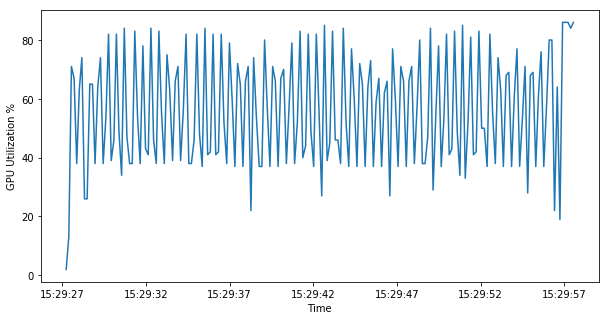

In [11]:
import pandas as pd

df = pd.DataFrame(monitor.buffer, columns=('timestamp', 'name', 'utilization'))
df = df.astype({'timestamp': 'datetime64', 'name': 'str', 'utilization': 'int8'})

plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'], df['utilization'])
plt.xlabel('Time')
plt.ylabel('GPU Utilization %')

Even though our preprocessing only takes a fraction of a second, it has a significant effect on our ability to fully utilize the GPU due to its blocking nature. 

Note that the utilization at the end of the session is higher. This is because we do not preprocess our data while validating the model on the test set, so we are only bound by the time it takes to transfer data from memory to the GPU. We would like to have this level of utilization during training as well!

# `tf.data.Dataset`

TensorFlow's `Dataset` functionality provides a simple solution to this problem. Here, we define `input_fn` which creates a `Dataset` from in-memory numpy tensor slices. With a real-world dataset that does not fit completely in memory, we would load examples from disk using something like `tf.data.FixedLengthRecordDataset`.

A `Dataset` contains methods to apply lazy functions over each element of the underlying data (  https://www.tensorflow.org/api_docs/python/tf/data/Dataset). Here, we map our `preprocess` function to each element, group the elements into `batch_size` batches, and prefetch `10` batches at a time. This effectively creates a queue which maintains at-most 10 batches of data, which our model consumes. 

After we have created the `Dataset`, we make it iterable.

In [12]:
def input_fn(images, labels, batch_size, is_train):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.map(lambda images, labels: (preprocess(images), labels))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(10)
    
    iterator = dataset.make_one_shot_iterator()
    batch_images, batch_labels = iterator.get_next()
    return batch_images, batch_labels

train_input_fn = input_fn(train_images, train_labels, batch_size, True)
test_input_fn = input_fn(test_images, test_labels, batch_size, False)

The iterator returns TensorFlow ops. We can evaluate them in a session.

In [13]:
train_input_fn

(<tf.Tensor 'IteratorGetNext:0' shape=(?, 28, 28) dtype=uint8>,
 <tf.Tensor 'IteratorGetNext:1' shape=(?,) dtype=uint8>)

In [14]:
with tf.Session() as sess:
    batch_images, batch_labels = sess.run(train_input_fn)
    
print(batch_images.shape, batch_labels.shape)

(512, 28, 28) (512,)


Let's re-run our example using these ops to feed our model.

Note that we cannot directly iterate over the batches returned by `train_input_fn` and `test_input_fn`, so we evaluate in a loop and break when we exhaust the iterator. Realistically, we would use an `Estimator` (https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator), which handles this logic for us reduces boilerplate.

In [15]:
train_loss = []
test_loss = []

with tf.Session() as sess:
    sess.run(init)
    
    monitor = GPUMonitor(0.1)
    monitor.start()
    
    # train
    while True:
        try:
            batch_inputs, batch_labels = sess.run(train_input_fn)
            l, _ = sess.run([loss, opt], feed_dict={inputs: batch_inputs, labels: batch_labels})
            train_loss.append(l)
            
        except tf.errors.OutOfRangeError:
            break
            
    # test
    while True:
        try:
            batch_inputs, batch_labels = sess.run(test_input_fn)
            l = sess.run(loss, feed_dict={inputs: batch_inputs, labels: batch_labels})
            test_loss.append(l)
            
        except tf.errors.OutOfRangeError:
            break
        
    monitor.stop()

Text(0,0.5,'GPU Utilization %')

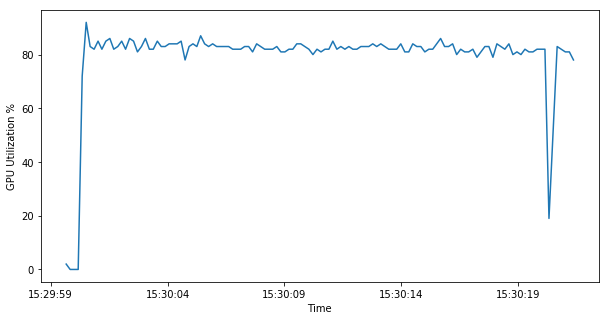

In [16]:
df = pd.DataFrame(monitor.buffer, columns=('timestamp', 'name', 'utilization'))
df = df.astype({'timestamp': 'datetime64', 'name': 'str', 'utilization': 'int8'})

plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'], df['utilization'])
plt.xlabel('Time')
plt.ylabel('GPU Utilization %')

Our GPU utilization is now much higher and more consistent. The only dip in utilization occurs when switching between our train and test sets where we defer to the CPU for a few operations. Overall, this small change sped up training time by over 30%.

# Best practices

For `Dataset` best practices, see the TensorFlow Input Pipeline Performance guide: https://www.tensorflow.org/performance/datasets_performance